## Simulation of 60-degree roto-translation of <110> dumbbells in dilute Fe-Si alloy.
In this notebook, we use the onsager calculator we created in part 1 to compute transport coefficients for the dumbbell-mediated mechanism for dilute Si solute in Fe.

The data of the energies are taken from the database given along with the paper by Messina et. al. - https://doi.org/10.1016/j.actamat.2020.03.038

The states were identified in Part 2, for the dilute Fe-Cr alloy, which we can use again.

We then compare the Green's function results for the drag and partial diffusion coefficient ratios with the results from SCMF calculations taken also from the above-mentioned database.

In [1]:
import numpy as np

from scipy.constants import physical_constants
kB = physical_constants['Boltzmann constant in eV/K'][0]
from matplotlib import pyplot as plt

import pickle
import time

In [2]:
%%time
with open("FeX_60RT.pkl","rb") as fl:
    onsagercalculator = pickle.load(fl)

CPU times: user 11min 4s, sys: 17 s, total: 11min 21s
Wall time: 11min 6s


In [3]:
# Assign same labels to the states as in the Fe-Cr notebook
name_to_themo_star = {"1nnA":1, "1nnB":2, "2nnA":4, "2nnB":3, "3nnA": 7, "3nnB":5, "3nnC":6,
       "4nnA":10,"4nnB":11,"4nnC":9, "5nnA":13, "5nnB":12}

In [4]:
# sorting out the jumps with the nomenclatures
jmpdict = {"1nnA_2nnA":[], "1nnA_2nnB":[], "1nnA_3nnB":[], "1nnA_3nnC":[], "1nnB_2nnB":[], "1nnB_3nnB":[],
          "1nnB_5nnB":[], "2nnA_4nnC":[], "2nnB_4nnB":[], "2nnB_4nnC":[]}
# Now identify the jumps and put them into the dictionaries
for jlistind, jlist in enumerate(onsagercalculator.jnet1):
    jmp = jlist[0]
    state1 = jmp.state1
    state2 = jmp.state2
    # if rigid jump, then continue
    if jmp.state1.db.iorind == jmp.state2.db.iorind:
        continue
    star1 = onsagercalculator.kinetic.complexIndexdict[state1][1]
    star2 = onsagercalculator.kinetic.complexIndexdict[state2][1]
    
    if star1 in onsagercalculator.thermo2kin and star2 in onsagercalculator.thermo2kin:
        thermo_star1 = onsagercalculator.thermo.complexIndexdict[state1][1]
        thermo_star2 = onsagercalculator.thermo.complexIndexdict[state2][1]
        name1 = ""
        name2 = ""
        #Now see which symmetry groups ("the stars") the states belong to
        star1found = False
        count1 = 0
        star2found = False
        count2 = 0
        for (key, value) in name_to_themo_star.items():
            if thermo_star1==value:
                star1found = True
                count1 += 1
                name1 = key
            if thermo_star2==value:
                star2found = True
                count2 += 1
                name2 = key
        # just to ensure we don't have any multiple counting business going on.
        # A state must be in one and only one star
        if count1>1:
            print(thermo_star1)
        if count2>1:
            print(thermo_star2)
        
        # Now concatenate names
        jname = name1+"_"+name2
        jnameRev = name2+"_"+name1
        try:
            jmpdict[jname].append(jlistind)
        except:
            try:
                # maybe the jump we have is the reverse of what we stored as the label in the dictionary?
                jmpdict[jnamerev].append(jlistind)
            
            except:    
                continue
jmpdict # Check that a jump has been found for every one in the jump dictionary

{'1nnA_2nnA': [6],
 '1nnA_2nnB': [1],
 '1nnA_3nnB': [5],
 '1nnA_3nnC': [3],
 '1nnB_2nnB': [4],
 '1nnB_3nnB': [2],
 '1nnB_5nnB': [7],
 '2nnA_4nnC': [8],
 '2nnB_4nnB': [9],
 '2nnB_4nnC': [10]}

In [5]:
# Next, we assign the supercell energies of the solute-dumbbell configurations from the database
E_f_pdb = 4.081701163
name_to_en = {"1nnA":-2079.59136864, "1nnB":-2080.03839805, "2nnA":-2079.70049869, "2nnB":-2079.80935148, 
              "3nnA":-2079.75574574, "3nnB":-2079.74713030, "3nnC":-2079.69119146, "4nnA":-2079.75368298, 
              "4nnB":-2079.84525470, "4nnC":-2079.78250279, "5nnA":-2079.76427954, "5nnB":-2079.80243840}

In [6]:
# Next, we compute formation energies of the solute-dumbbell configurations.
E_sup_pdb = -2081.44451396
E_sup_solute = -2075.53747594 
E_bulk = -2077.21734574  #E_bulk is the same as E_ref
name_to_Ef = {}
for (key, E_IB) in name_to_en.items():
    # get the binding energy first
    Eb = -E_IB + E_sup_pdb + E_sup_solute - E_bulk
    # Next, get the formation energy (relative to solute formation energy)
    name_to_Ef[key] = E_f_pdb - Eb

name_to_Ef

{'1nnA': 4.254976683000516,
 '1nnB': 3.8079472730003747,
 '2nnA': 4.145846633000312,
 '2nnB': 4.036993843000639,
 '3nnA': 4.090599583000605,
 '3nnB': 4.0992150230002355,
 '3nnC': 4.155153863000416,
 '4nnA': 4.092662343000322,
 '4nnB': 4.001090623000275,
 '4nnC': 4.0638425330005905,
 '5nnA': 4.082065783000255,
 '5nnB': 4.043906923000415}

In [7]:
# The complex energies are set. Now, we set the mixed dumbbell energies
E_b_mdb = 2079.76221064 + E_sup_pdb + E_sup_solute - E_bulk
E_f_mdb = E_f_pdb - E_b_mdb

In [8]:
# SCMF transition state energy values from the database of Messina et. al.
# J_3_1nnA_2nnA   -2079.2970      
# J_3_1nnA_2nnB   -2079.3621      
# J_3_1nnA_3nnB   -2079.3136      
# J_3_1nnA_3nnC   -2079.2797      
# J_3_1nnB_2nnB   -2079.5994      
# J_3_1nnB_3nnB   -2079.5636      
# J_3_1nnB_5nnB   -2079.5626      
# J_3_2nnA_4nnC   -2079.3122      
# J_3_2nnB_4nnB   -2079.5204      
# J_3_2nnB_4nnC   -2079.4476      


Jname_2_TS_en = {"1nnA_2nnA": -2079.2970, "1nnA_2nnB": -2079.3621, "1nnA_3nnB": -2079.3136,
                 "1nnA_3nnC": -2079.2797, "1nnB_2nnB": -2079.5994, "1nnB_3nnB": -2079.5636,
                 "1nnB_5nnB": -2079.5626, "2nnA_4nnC": -2079.3122, "2nnB_4nnB": -2079.5204, 
                 "2nnB_4nnC": -2079.4476}

In [9]:
# Now, we have to find the TS formation energies.
Jname_2_ef_ts = {}
for (key, E_IB) in Jname_2_TS_en.items():
    Eb = -E_IB + E_sup_pdb + E_sup_solute - E_bulk
    # Next, get the formation energy (relative to solute formation energy)
    Jname_2_ef_ts[key] = E_f_pdb - Eb

In [10]:
Jname_2_mig = {}
for (key, TS_en) in Jname_2_ef_ts.items():
    initstar = key[:4]
    Jname_2_mig[key] = TS_en - name_to_Ef[initstar]
Jname_2_mig

{'1nnA_2nnA': 0.29436863999990237,
 '1nnA_2nnB': 0.22926864000010028,
 '1nnA_3nnB': 0.2777686399999766,
 '1nnA_3nnC': 0.3116686399998798,
 '1nnB_2nnB': 0.43899805000000924,
 '1nnB_3nnB': 0.47479805000011766,
 '1nnB_5nnB': 0.47579804999986663,
 '2nnA_4nnC': 0.3882986900002834,
 '2nnB_4nnB': 0.2889514799999233,
 '2nnB_4nnC': 0.3617514799998389}

In [11]:
# omega2 and omega43 roto-translation jumps
E_IB_43, E_IB_2 = -2079.69306384,  -2079.1947
Eb_43, Eb_2 = -E_IB_43 + E_sup_pdb + E_sup_solute - E_bulk, -E_IB_2 + E_sup_pdb + E_sup_solute - E_bulk 
# Next, get the formation energy (relative to solute formation energy)
ef_ts_43 = E_f_pdb - Eb_43
ef_ts_2 = E_f_pdb - Eb_2

## Si calculations

In [12]:
# Jump rates and energy barriers set. Now, let's set the calculations up.
vu0 = 4.4447 # attempt frequencies of pure dumbbell jumps. 
vu2 = 19.2684 # attempt frequencies of mixed dumbbell jumps.
Dconv=1e-2 # to have units in cm^2/s from nm^2*THz

# pre-factors and formation energies for pure dumbbell jumps
predb0, enedb0 = np.ones(1)*np.exp(0.050), np.array([E_f_pdb])

# Here on, pre-factors are going to 1.0
# We'll measure every formation energy relative to the solute formation energy.
preS, eneS = np.ones(1), np.array([0.0])

# Next, interaction or the excess energies and pre-factors for solutes and dumbbells.
preSdb, eneSdb = np.ones(onsagercalculator.thermo.mixedstartindex), \
                 np.zeros(onsagercalculator.thermo.mixedstartindex)
# Now, we go over the necessary stars and assign interaction energies
for (key, index) in name_to_themo_star.items():
    eneSdb[index] = name_to_Ef[key] - E_f_pdb

predb2, enedb2 = np.ones(1), np.array([E_f_mdb])

# Transition state energies
# Omega0 TS eneriges
preT0, eneT0 = Dconv*vu0*np.ones(1), np.array([E_f_pdb+0.335115123])

# Omega2 TS energies
Nj2 = len(onsagercalculator.jnet2)
preT2, eneT2 = Dconv*vu2*np.ones(Nj2), np.array([ef_ts_2])

# Omega43 TS energies
preT43, eneT43 = Dconv*vu0*np.ones(1), np.array([ef_ts_43])

# Omega1 TS energies - need to be careful here
preT1 = Dconv*vu0*np.ones(len(onsagercalculator.jnet1))
eneT1 = np.array([eneT0[i] for i in onsagercalculator.om1types])
# Now, we go over the jumps that are provided and make the necessary changes
for (key, index) in jmpdict.items():
    eneT1[index] = Jname_2_ef_ts[key]

In [13]:
# Then we calculate the transport coefficients
from tqdm import tqdm

# set the temperatures
temp = np.arange(200, 4001, 10)

diff_aa_Si = np.zeros(len(temp))
diff_ab_Si = np.zeros(len(temp))
diff_bb = np.zeros(len(temp))
diff_bb_non_loc = np.zeros(len(temp))

start = time.time()
for i in tqdm(range(len(temp)), position=0, leave=True, ncols=65):
    T = temp[i]
    kT = kB*T
    bFdb0, bFdb2, bFS, bFSdb, bFT0, bFT1, bFT2, bFT3, bFT4 = \
        onsagercalculator.preene2betafree(kT, predb0, enedb0, preS, eneS, preSdb, eneSdb, predb2, enedb2,
                                               preT0, eneT0, preT2, eneT2, preT1, eneT1, preT43, eneT43)

    # get the transport coefficients - "a" is the solute, "b" is the solvent (Fe).
    # The uncorrelated (L_uc) and correlated (L_c) parts will be summed to get the total
    # transport coefficients.
    L0bb, (L_uc_aa,L_c_aa), (L_uc_bb,L_c_bb), (L_uc_ab,L_c_ab)=\
    onsagercalculator.L_ij(bFdb0, bFT0, bFdb2, bFT2, bFS, bFSdb, bFT1, bFT3, bFT4)
    
    L_aa = L_uc_aa + L_c_aa
    L_bb = L_uc_bb + L_c_bb
    L_ab = L_uc_ab + L_c_ab
    
    diff_aa_Si[i] = L_aa[0][0]
    diff_ab_Si[i] = L_ab[0][0]
    diff_bb[i] = L_bb[0][0]
    diff_bb_non_loc[i] = L0bb[0][0]
        
print(time.time() - start)

100%|██████████████████████████| 381/381 [37:43<00:00,  5.94s/it]

2263.6649363040924


In [14]:
# Now let's do the infinite temeperature limit
kT = np.inf
bFdb0, bFdb2, bFS, bFSdb, bFT0, bFT1, bFT2, bFT3, bFT4 = \
    onsagercalculator.preene2betafree(kT, predb0, enedb0, preS, eneS, preSdb, eneSdb, predb2, enedb2,
                                           preT0, eneT0, preT2, eneT2, preT1, eneT1, preT43, eneT43)
# get the transport coefficients
L0bb, (L_uc_aa,L_c_aa), (L_uc_bb,L_c_bb), (L_uc_ab,L_c_ab)=\
onsagercalculator.L_ij(bFdb0, bFT0, bFdb2, bFT2, bFS, bFSdb, bFT1, bFT3, bFT4)

L_aa = L_uc_aa + L_c_aa
L_bb = L_uc_bb + L_c_bb
L_ab = L_uc_ab + L_c_ab

drag_inf = L_ab[0][0]/L_aa[0][0]

In [15]:
# Save all the data for plotting later on
import h5py
with h5py.File("Si_data.h5","w") as fl:
    fl.create_dataset("diff_aa", data=diff_aa_Si)
    fl.create_dataset("diff_ab", data=diff_ab_Si)
    fl.create_dataset("diff_bb_nl", data=diff_bb_non_loc)
    fl.create_dataset("diff_bb", data=diff_bb)
    fl.create_dataset("drag_inf", data=np.array([drag_inf]))
    fl.create_dataset("Temp", data=temp)

In [16]:
# Now, we load the SCMF drag and PDC ratios extracted from Messina et. al.'s results to compare

# First the drag ratios
Drag_dat_SCMF = []
with open("../SCMF_Messina_et_al/DragRatio_Si.dat","r") as fl:
    for line in fl:
        arr = line.split()
        Drag_dat_SCMF.append(float(arr[0]))
Drag_dat_SCMF = np.array(Drag_dat_SCMF)

# Then the pdc ratios
PDC_dat_SCMF = []
with open("../SCMF_Messina_et_al/PDC_ratio_Si.dat","r") as fl:
    for line in fl:
        arr = line.split()
        PDC_dat_SCMF.append(float(arr[1])) # the temperatures are the first values in the PDC files

PDC_dat_SCMF = np.array(PDC_dat_SCMF)

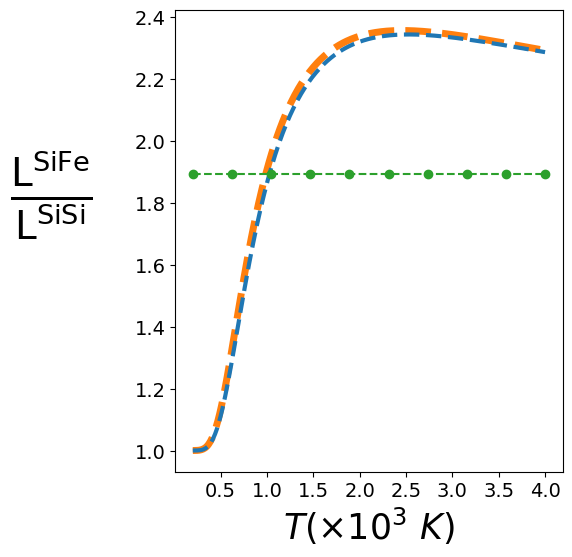

In [17]:
# Then we plot and compare the two results - we show the drag ratios here
colorGF = "tab:blue"
colorMessina = "tab:orange"

colorInf = "tab:green"

infAll = "tab:green"
inf60 = infAll

lwMessina = 5
lwGF = 3

tempScale = temp/1000.
tempSpace = np.linspace(tempScale[0], tempScale[-1], 10, endpoint=True)

plt.figure(figsize=(5,6))
plt.plot(tempScale, Drag_dat_SCMF, ls="--", color=colorMessina, lw=lwMessina)
plt.plot(tempScale, diff_ab_Si/diff_aa_Si, ls="--", color=colorGF, lw=lwGF)
plt.plot(tempSpace, np.ones_like(tempSpace)*drag_inf, ls='--', color=inf60, marker="o")
plt.xlabel(r'$T (\times 10^3 \ K)$', fontsize = 25)
plt.ylabel(r'$\mathrm{\frac{L^{SiFe}}{L^{SiSi}}}$', rotation=0, labelpad = 60, fontsize = 40)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()